In [1]:
from dataset import CropFlipGenerateMask, init_patch_matching_tracker, InceptionCropWithMask, LOCATransform
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

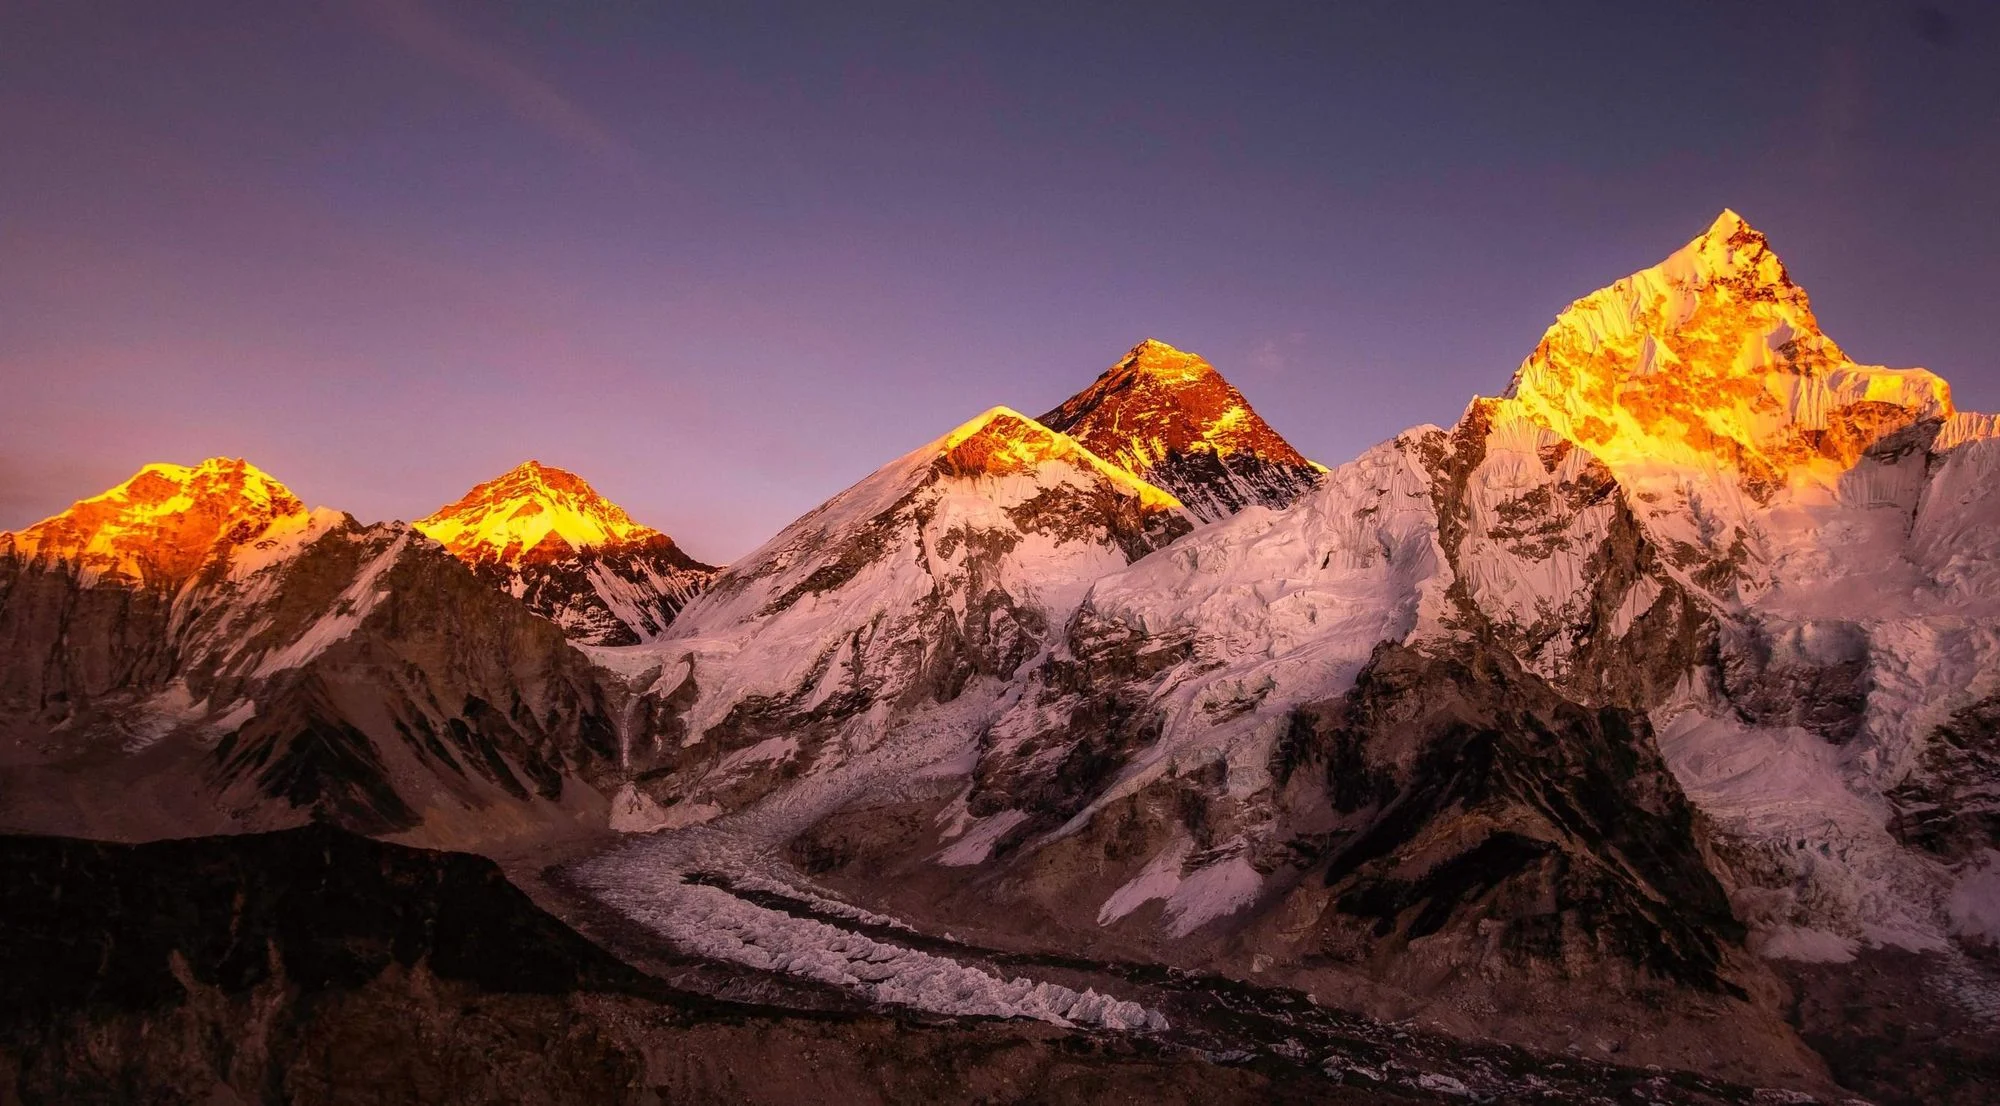

In [2]:
# Load image using PIL
img = Image.open("resources/img.png")
img

### Convert image to tensor

In [3]:
img = transforms.ToTensor()(img)
img = transforms.Resize((224, 224))(img)
img = img[:3]
img.shape

torch.Size([3, 224, 224])

### Create reference crop and mask

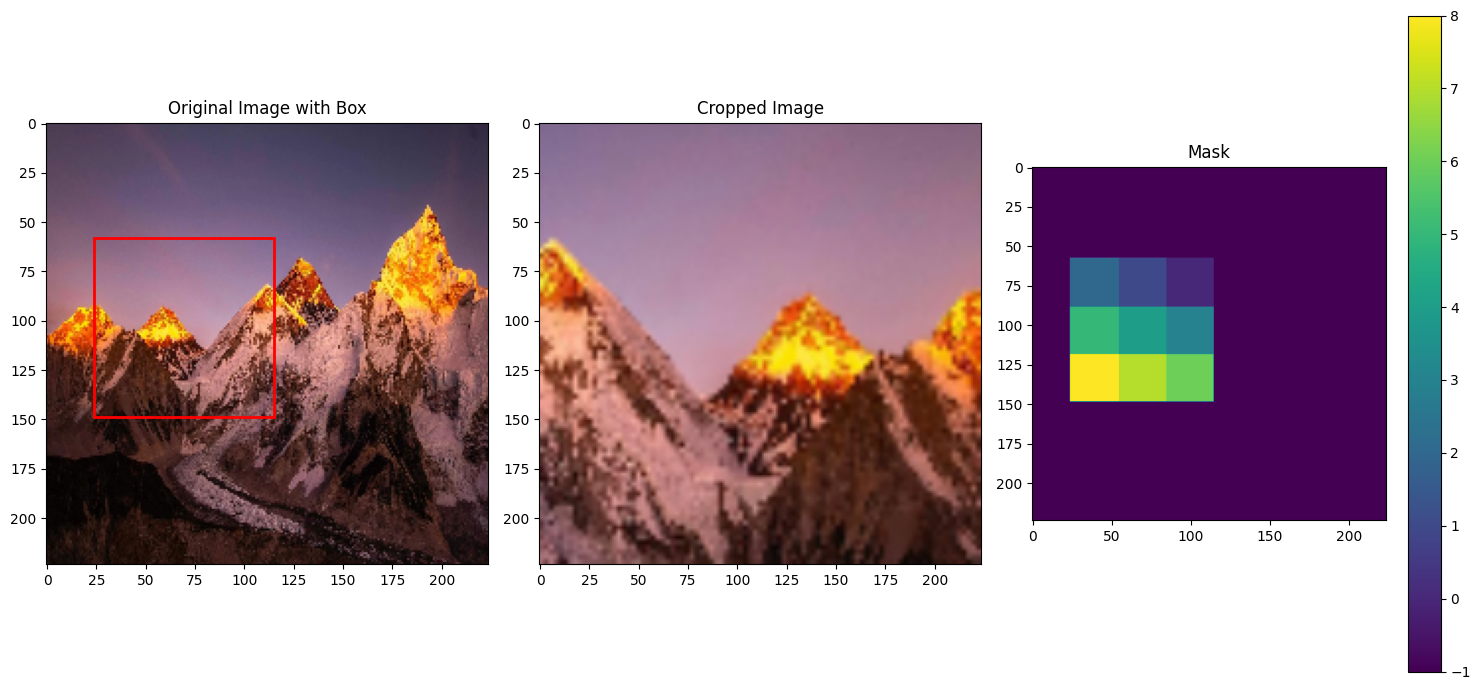

In [4]:
mask = init_patch_matching_tracker(3)
crop_flip_generate_mask = CropFlipGenerateMask()
ref_crop, ref_mask, ref_box = crop_flip_generate_mask(img, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

# Plot original image with box
ax1.imshow(img.permute(1, 2, 0))

y, x, h, w = ref_box[1:]
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Original Image with Box')

# Plot crop
ax2.imshow(ref_crop.permute(1, 2, 0))
ax2.set_title('Cropped Image')

# Plot mask
mask_vis = plt.imshow(ref_mask.squeeze(0), cmap='viridis')
plt.colorbar(mask_vis)
ax3.set_title('Mask')

plt.tight_layout()
plt.show()

### Visualize reference and query crop and mask

In [5]:
mask = init_patch_matching_tracker(3)
crop_flip_generate_mask = CropFlipGenerateMask()
ref_crop, ref_mask, ref_box = crop_flip_generate_mask(img, mask)

inception_crop_with_mask = InceptionCropWithMask(
    resize_size=(96, 96), area_min=5, area_max=32, resize_mask=(6, 6))

q_crop, q_mask, q_rel_box, q_box = inception_crop_with_mask(img, ref_mask, ref_box)
q_crop.shape, q_mask.shape, q_rel_box

(torch.Size([3, 96, 96]),
 torch.Size([1, 6, 6]),
 tensor([1.0000, 0.3714, 0.0095, 0.5238, 0.5857]))

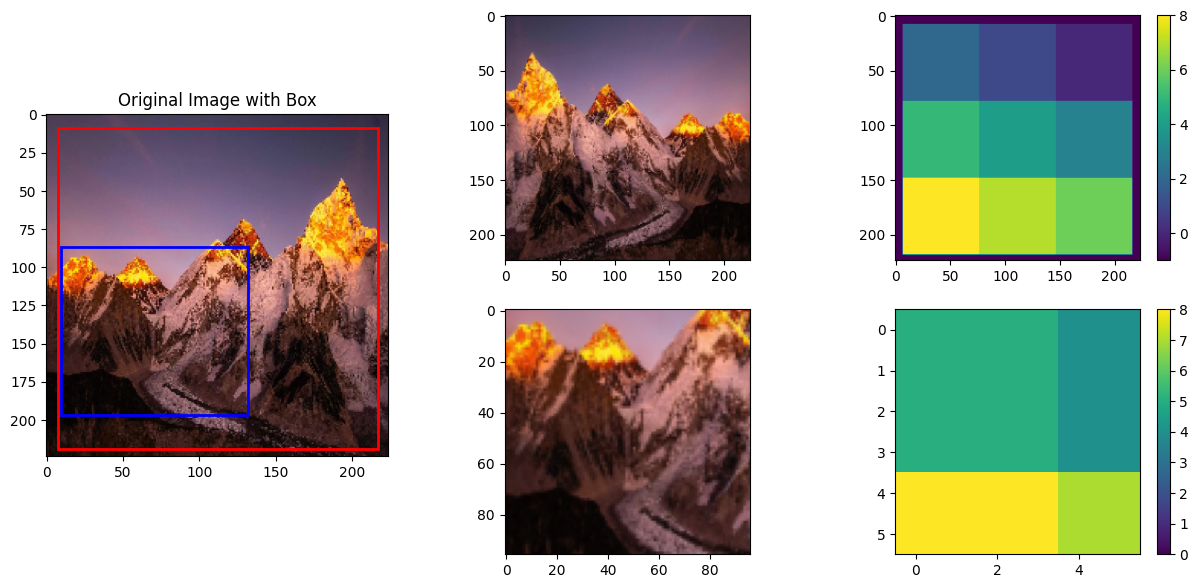

In [6]:
fig = plt.figure(figsize=(15, 7))

gs0 = gridspec.GridSpec(1, 3, figure=fig)

# Plot original image with reference and query bbox
gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0])
ax1.imshow(img.permute(1, 2, 0))
y, x, h, w = ref_box[1:]
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Original Image with Box')

y, x, h, w = q_box[1:]
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
ax1.add_patch(rect)

# Plot reference and query crop
gs01 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1])
ax2 = fig.add_subplot(gs01[0])
ax2.imshow(ref_crop.permute(1, 2, 0))

ax3 = fig.add_subplot(gs01[1])
ax3.imshow(q_crop.permute(1, 2, 0))

# Plot reference and query mask
gs02 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[2])
ax4 = fig.add_subplot(gs02[0])
mask_vis = ax4.imshow(ref_mask.squeeze(0), cmap='viridis')
plt.colorbar(mask_vis)

ax5 = fig.add_subplot(gs02[1])
mask_vis = ax5.imshow(q_mask.squeeze(0), cmap='viridis', vmin=0, vmax=8)
plt.colorbar(mask_vis)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


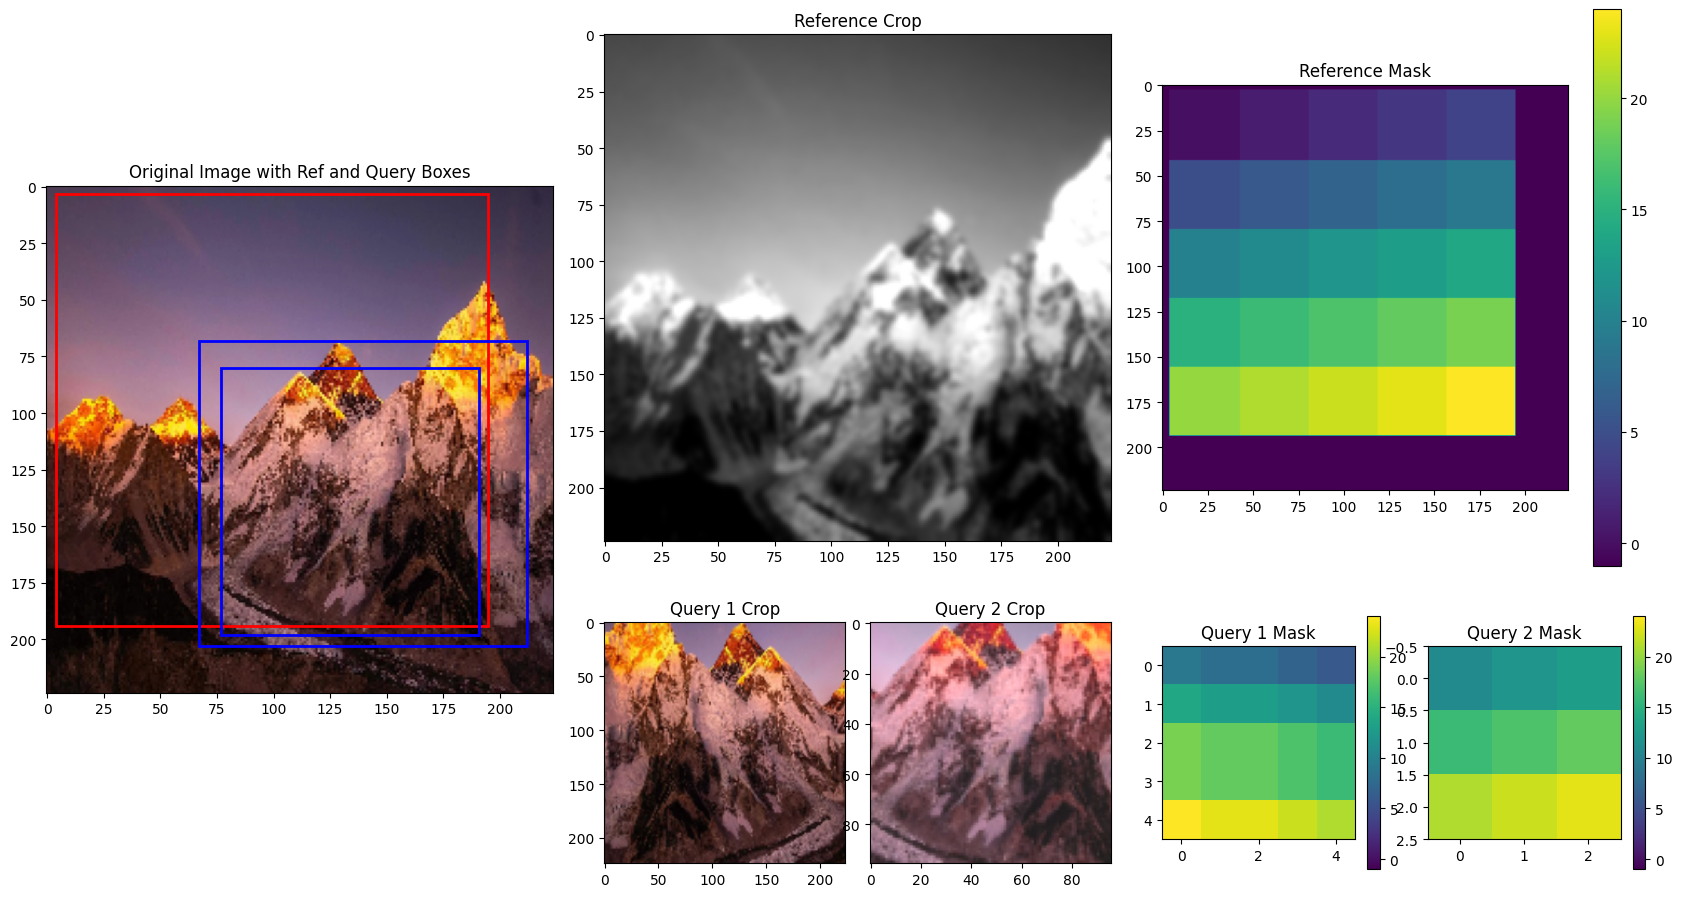

In [97]:
ref, ref_mask, ref_box, queries = LOCATransform(n_queries=2, ref_mask_size=5, query_mask_size=3)(img)

fig = plt.figure(figsize=(17, 9))

gs0 = gridspec.GridSpec(1, 3, figure=fig)

# Plot original image with reference and queries bbox
gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0])
ax1.imshow(img.permute(1, 2, 0))
y, x, h, w = ref_box[1:]

rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Original Image with Ref and Query Boxes')

for query in queries[:]:
    y, x, h, w = query[3][1:]
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
    ax1.add_patch(rect)

# Plot reference and query crops
gs01 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs0[1])
ax2 = fig.add_subplot(gs01[:2, :])
ax2.imshow((ref.permute(1, 2, 0) * torch.tensor(LOCATransform.STDDEV_RGB) + torch.tensor(LOCATransform.MEAN_RGB)) * 255)
ax2.set_title('Reference Crop')

for i, query in enumerate(queries[:]):
    ax = fig.add_subplot(gs01[2, i])
    ax.imshow((query[0].permute(1, 2, 0) * torch.tensor(LOCATransform.STDDEV_RGB) + torch.tensor(LOCATransform.MEAN_RGB)) * 255)
    ax.set_title(f'Query {i + 1} Crop')
    
# Plot reference and query masks
gs02 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs0[2])
ax3 = fig.add_subplot(gs02[:2, :])
mask_vis = ax3.imshow(ref_mask.squeeze(0), cmap='viridis')
plt.colorbar(mask_vis)
ax3.set_title('Reference Mask')

for i, query in enumerate(queries[:]):
    ax = fig.add_subplot(gs02[2, i])
    mask_vis = ax.imshow(query[1].squeeze(0), cmap='viridis', vmin=-1, vmax=ref_mask.max())
    plt.colorbar(mask_vis)
    ax.set_title(f'Query {i + 1} Mask')
    
plt.tight_layout()
plt.show()

In [83]:
len(queries[0][3])

5

In [19]:
(ref.permute(1, 2, 0) * torch.tensor(LOCATransform.STDDEV_RGB) + torch.tensor(LOCATransform.MEAN_RGB)) * 255

tensor([[[0.2948, 0.2444, 0.3469],
         [0.2945, 0.2443, 0.3467],
         [0.2936, 0.2435, 0.3457],
         ...,
         [0.1743, 0.1582, 0.2726],
         [0.1742, 0.1579, 0.2714],
         [0.1743, 0.1580, 0.2709]],

        [[0.2946, 0.2443, 0.3468],
         [0.2946, 0.2443, 0.3467],
         [0.2940, 0.2439, 0.3462],
         ...,
         [0.1747, 0.1590, 0.2729],
         [0.1747, 0.1588, 0.2718],
         [0.1749, 0.1589, 0.2712]],

        [[0.2946, 0.2442, 0.3468],
         [0.2948, 0.2445, 0.3470],
         [0.2951, 0.2448, 0.3473],
         ...,
         [0.1758, 0.1606, 0.2736],
         [0.1761, 0.1608, 0.2725],
         [0.1763, 0.1609, 0.2718]],

        ...,

        [[0.1187, 0.0273, 0.0325],
         [0.1211, 0.0281, 0.0325],
         [0.1264, 0.0299, 0.0327],
         ...,
         [0.0744, 0.0306, 0.0372],
         [0.0688, 0.0275, 0.0359],
         [0.0662, 0.0262, 0.0352]],

        [[0.1205, 0.0299, 0.0351],
         [0.1201, 0.0291, 0.0335],
         [0.

In [12]:
ref.shape

torch.Size([3, 224, 224])